# Sephora Customer Segmentation (Refined)

This notebook performs customer segmentation based on processed customer and product data. The primary goal is to group customers into distinct clusters using relevant features and output a CSV file mapping each `client_id` to a `cluster_id`.

**Key changes in this version:**
* Loads data from `data/processed/reviews.csv` and `data/processed/skincare_product_info.csv`.
* Uses the Silhouette method for determining the optimal number of clusters.
* Emphasizes careful feature engineering and selection for customer segmentation based on provided column names.

The process involves:
1.  Loading pre-processed data.
2.  Merging the processed data.
3.  Engineering features that describe customer behavior and preferences.
4.  Determining optimal cluster count using Silhouette analysis.
5.  Applying K-Means clustering.
6.  Analyzing cluster characteristics.
7.  Exporting the segmentation results.

In [1]:
import pandas as pd
import numpy as np
import glob
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score # For Silhouette analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Define the base path for PROCESSED data
PROCESSED_DATA_PATH = "../data/processed/"

print("Libraries imported and PROCESSED_DATA_PATH set to:", PROCESSED_DATA_PATH)

Libraries imported and PROCESSED_DATA_PATH set to: ../data/processed/


## Cell 3: Load Processed Data & Initial Merge

In [2]:
# This cell loads processed reviews.csv and skincare_product_info.csv, then merges them.
# The output of this cell will be `merged_df`.

print(f"Looking for processed data in: {PROCESSED_DATA_PATH}")

# Define file names
processed_reviews_file = "reviews.csv"
processed_products_file = "skincare_product_info.csv"

reviews_csv_path = os.path.join(PROCESSED_DATA_PATH, processed_reviews_file)
products_csv_path = os.path.join(PROCESSED_DATA_PATH, processed_products_file)

# Load processed reviews data
try:
    reviews_df = pd.read_csv(reviews_csv_path)
    print(f"Successfully loaded {processed_reviews_file}. Shape: {reviews_df.shape}")
    print("Columns in processed reviews_df:", reviews_df.columns.tolist())
    print("\nProcessed Reviews DataFrame Sample:")
    print(reviews_df.head())
except FileNotFoundError:
    print(f"Error: {reviews_csv_path} not found.")
    reviews_df = pd.DataFrame()
except Exception as e:
    print(f"An error occurred loading {processed_reviews_file}: {e}")
    reviews_df = pd.DataFrame()

# Load processed product information
try:
    products_df = pd.read_csv(products_csv_path)
    print(f"\nSuccessfully loaded {processed_products_file}. Shape: {products_df.shape}")
    print("Columns in processed skincare_product_info_df (products_df):", products_df.columns.tolist())
    print("\nProcessed Products DataFrame Sample:")
    print(products_df.head())
except FileNotFoundError:
    print(f"Error: {products_csv_path} not found.")
    products_df = pd.DataFrame()
except Exception as e:
    print(f"An error occurred loading {processed_products_file}: {e}")
    products_df = pd.DataFrame()

# --- Proceed with merging if both DataFrames are loaded ---
if products_df.empty or reviews_df.empty:
    print("\nCannot proceed with merging as one or both processed dataframes are missing/empty.")
    merged_df = pd.DataFrame()
else:
    print("\n--- Starting Data Preprocessing & Merge of Processed Files ---")
    
    # Ensure 'product_id' columns exist and their types match for merging
    if 'product_id' not in reviews_df.columns:
        print("Error: 'product_id' column missing in processed reviews.csv.")
    if 'product_id' not in products_df.columns:
        print("Error: 'product_id' column missing in processed skincare_product_info.csv.")

    if 'product_id' in reviews_df.columns and 'product_id' in products_df.columns:
        products_df['product_id'] = products_df['product_id'].astype(str)
        reviews_df['product_id'] = reviews_df['product_id'].astype(str)

        client_id_col_in_reviews = 'author_id' # As per your reviews.csv schema
        if client_id_col_in_reviews not in reviews_df.columns:
            print(f"Error: Client identifier column '{client_id_col_in_reviews}' not found in reviews.csv.")
            merged_df = pd.DataFrame() # Halt merge
        else:
            reviews_df.dropna(subset=[client_id_col_in_reviews, 'product_id'], inplace=True)
            print(f"Reviews_df shape after dropping NA {client_id_col_in_reviews}/product_id: {reviews_df.shape}")
            
            merged_df = pd.merge(reviews_df, products_df, on="product_id", how="left", suffixes=('_review', '_product'))
            print(f"\nMerged data shape: {merged_df.shape}")
            print("Columns in merged_df after merge:", merged_df.columns.tolist())
            
            # --- Create 'is_on_sale' feature ---
            # Using 'discount_usd_product' from skincare_product_info.csv (after merge)
            # Your skincare_product_info.csv has 'discount_usd'. After merge, it becomes 'discount_usd_product'
            # because 'reviews.csv' also has a 'discount_usd' column.
            discount_column_from_product_info = 'discount_usd_product' 
            if discount_column_from_product_info in merged_df.columns:
                # Ensure the column is numeric before comparison
                merged_df[discount_column_from_product_info] = pd.to_numeric(merged_df[discount_column_from_product_info], errors='coerce')
                merged_df['is_on_sale'] = merged_df[discount_column_from_product_info] > 0
                print(f"Created 'is_on_sale' based on '{discount_column_from_product_info} > 0'.")
            else:
                print(f"Warning: Column '{discount_column_from_product_info}' (expected from skincare_product_info.csv after merge) not found. 'is_on_sale' defaulting to False.")
                merged_df['is_on_sale'] = False
                
            print("\nMerged Data Sample:")
            # Display a few key columns including the client ID, product ID, and the new 'is_on_sale'
            display_cols_sample = [client_id_col_in_reviews, 'product_id', 'is_on_sale']
            # Try to show a price column for context, preferring the one from skincare_product_info
            price_col_for_sample = 'actual_price_usd_product' if 'actual_price_usd_product' in merged_df.columns else ('actual_price_usd_review' if 'actual_price_usd_review' in merged_df.columns else None)
            if price_col_for_sample:
                display_cols_sample.insert(2, price_col_for_sample)
            print(merged_df[display_cols_sample].head())
    else:
        print("Halting merge due to missing 'product_id' columns in one or both dataframes.")
        merged_df = pd.DataFrame()

Looking for processed data in: ../data/processed/


/var/folders/xw/4r23rrh93fvbvkd3w5nzg6m40000gn/T/ipykernel_2349/3640406453.py:15: DtypeWarning: Columns (0,1,4,6,7,8,9,10,11,12,13,14,15,16,19,20,21,23,24,27,29,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_df = pd.read_csv(reviews_csv_path)


Successfully loaded reviews.csv. Shape: (1406503, 34)
Columns in processed reviews_df: ['author_id', 'user_rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'actual_price_usd', 'brand_id', 'discount_usd', 'highlights', 'ingredients', 'limited_edition', 'loves_count', 'new', 'online_only', 'out_of_stock', 'primary_category', 'reviews', 'secondary_category', 'sephora_exclusive', 'size', 'tertiary_category', 'review_length']

Processed Reviews DataFrame Sample:
     author_id user_rating  is_recommended  helpfulness total_feedback_count  \
0   1741593524           5             1.0          1.0                    2   
1  31423088263           1             0.0          NaN                    0   
2   5061282401           5             1.0          NaN                    0  

## Cell 4: Feature Engineering & Selection

In [3]:
import pandas as pd
import numpy as np

# This cell takes merged_df (from Cell 3) and engineers customer-level features.
# It then allows for selection of these features for clustering.

if 'merged_df' not in locals() or not isinstance(merged_df, pd.DataFrame) or merged_df.empty:
    print("merged_df is not available or empty. Skipping Feature Engineering & Selection.")
    customer_df = pd.DataFrame() # Ensure defined for later checks
    customer_df_for_clustering = pd.DataFrame() # Ensure defined for later checks
else:
    print("\n--- Starting Feature Engineering (from merged_df) ---")
    
    # --- Step 1: Prepare client identifier ---
    CLIENT_ID_COLUMN_NAME = 'author_id' # From your reviews.csv schema

    if CLIENT_ID_COLUMN_NAME not in merged_df.columns:
        print(f"CRITICAL ERROR: Client ID column '{CLIENT_ID_COLUMN_NAME}' not found in merged_df.")
        print(f"Available columns: {merged_df.columns.tolist()}")
        customer_df = pd.DataFrame()
        customer_df_for_clustering = pd.DataFrame() # Ensure defined
    else:
        # Ensure CLIENT_ID_COLUMN_NAME is suitable for grouping
        merged_df.dropna(subset=[CLIENT_ID_COLUMN_NAME], inplace=True)
        # Attempt conversion to numeric first to handle mixed types, then to int
        # This handles cases where it might be numeric but as strings or floats
        merged_df[CLIENT_ID_COLUMN_NAME] = pd.to_numeric(merged_df[CLIENT_ID_COLUMN_NAME], errors='coerce')
        merged_df.dropna(subset=[CLIENT_ID_COLUMN_NAME], inplace=True) # Drop if not convertible to numeric
        merged_df[CLIENT_ID_COLUMN_NAME] = merged_df[CLIENT_ID_COLUMN_NAME].astype(np.int64)

        # --- Step 2: Define actual source column names from merged_df ---
        # These are based on your provided CSV structures and the merge in Cell 3 (suffixes: '_review', '_product')

        # Features from reviews.csv part of merged_df:
        REVIEW_RATING_COL = 'user_rating' 
        REVIEW_RECOMMENDED_COL = 'is_recommended'
        
        # Features from skincare_product_info.csv part of merged_df
        PRODUCT_PRICE_COL = 'actual_price_usd_product' 
        PRODUCT_RATING_COL = 'rating' 
        PRODUCT_LOVES_COL = 'loves_count_product'      
        PRODUCT_BRAND_COL = 'brand_name_product'      
        PRODUCT_CATEGORY_COL = 'primary_category_product' 
        PRODUCT_LIMITED_EDITION_COL = 'limited_edition_product' 
        PRODUCT_NEW_COL = 'new_product'               
        PRODUCT_ONLINE_ONLY_COL = 'online_only_product' 
        PRODUCT_SEPHORA_EXCLUSIVE_COL = 'sephora_exclusive_product' 
        
        PRODUCT_IS_ON_SALE_COL = 'is_on_sale' # Engineered in Cell 3

        print("\n--- Confirming availability and Pre-cleaning Numeric Source Columns ---")
        source_columns_map = {
            REVIEW_RATING_COL: "reviews.csv ('user_rating')",
            REVIEW_RECOMMENDED_COL: "reviews.csv ('is_recommended')",
            PRODUCT_PRICE_COL: "skincare_product_info.csv ('actual_price_usd_product')",
            PRODUCT_RATING_COL: "skincare_product_info.csv ('rating')",
            PRODUCT_LOVES_COL: "skincare_product_info.csv ('loves_count_product')",
            PRODUCT_BRAND_COL: "skincare_product_info.csv ('brand_name_product')",
            PRODUCT_CATEGORY_COL: "skincare_product_info.csv ('primary_category_product')",
            PRODUCT_LIMITED_EDITION_COL: "skincare_product_info.csv ('limited_edition_product')",
            PRODUCT_NEW_COL: "skincare_product_info.csv ('new_product')",
            PRODUCT_ONLINE_ONLY_COL: "skincare_product_info.csv ('online_only_product')",
            PRODUCT_SEPHORA_EXCLUSIVE_COL: "skincare_product_info.csv ('sephora_exclusive_product')",
            PRODUCT_IS_ON_SALE_COL: "Engineered in Cell 3 ('is_on_sale')"
        }
        
        all_source_cols_found = True
        for col_name, col_source_desc in source_columns_map.items():
            if col_name not in merged_df.columns:
                print(f"Warning: Expected source column '{col_name}' (for {col_source_desc}) NOT FOUND in merged_df. Related features will be NaN or cause errors.")
                all_source_cols_found = False
            else:
                # --- Data Cleaning and Type Conversion ---
                if col_name == PRODUCT_PRICE_COL:
                    print(f"Cleaning and converting '{col_name}' to numeric...")
                    # Convert to string first to handle potential mixed types before replace
                    merged_df[col_name] = merged_df[col_name].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
                    merged_df[col_name] = pd.to_numeric(merged_df[col_name], errors='coerce')
                    if merged_df[col_name].isnull().any():
                         print(f"  NaNs introduced in '{col_name}' after cleaning. Original non-numeric values are now NaN.")
                elif col_name in [REVIEW_RATING_COL, PRODUCT_RATING_COL, PRODUCT_LOVES_COL, REVIEW_RECOMMENDED_COL]:
                    # For other numeric columns used in mean/sum, ensure they are numeric
                    print(f"Converting '{col_name}' to numeric...")
                    merged_df[col_name] = pd.to_numeric(merged_df[col_name], errors='coerce')
                    if merged_df[col_name].isnull().any():
                         print(f"  NaNs may exist or were introduced in '{col_name}' after conversion.")
                elif col_name in [PRODUCT_LIMITED_EDITION_COL, PRODUCT_NEW_COL, PRODUCT_ONLINE_ONLY_COL, PRODUCT_SEPHORA_EXCLUSIVE_COL, PRODUCT_IS_ON_SALE_COL]:
                    # For boolean-like columns that will be cast to float in lambda
                    # If they are True/False or 1/0, astype(float) in lambda is fine.
                    # If they are strings like "TRUE", "FALSE", they would need specific mapping.
                    # For now, we assume they are compatible or pd.to_numeric can handle them if they are "1"/"0" strings.
                    # To be safe, one could also apply pd.to_numeric here if they are expected as "0" or "1" strings.
                    # For example:
                    # merged_df[col_name] = pd.to_numeric(merged_df[col_name], errors='coerce')
                    # However, the original lambda `x.astype(float).mean()` handles booleans and numeric 0/1 correctly.
                    pass


        if all_source_cols_found:
            print("All key source columns for feature engineering appear to be available and have been pre-processed in merged_df.")
        print("--- End of source column confirmation and pre-cleaning ---\n")
        
        # --- Step 3: Calculate features per customer using groupby().agg() ---
        print("Calculating customer features using groupby().agg()...")
        
        agg_functions = {}
        # Ensure column exists and is numeric (or convertible) before adding to agg_functions
        if REVIEW_RATING_COL in merged_df.columns and pd.api.types.is_numeric_dtype(merged_df[REVIEW_RATING_COL]):
            agg_functions['avg_rating_given'] = (REVIEW_RATING_COL, 'mean')
        
        if REVIEW_RECOMMENDED_COL in merged_df.columns and pd.api.types.is_numeric_dtype(merged_df[REVIEW_RECOMMENDED_COL]): # Often 0/1
            agg_functions['prop_recommended'] = (REVIEW_RECOMMENDED_COL, 'mean')
        
        agg_functions['num_reviews'] = (CLIENT_ID_COLUMN_NAME, 'count') # Count based on the ID column itself

        if PRODUCT_PRICE_COL in merged_df.columns and pd.api.types.is_numeric_dtype(merged_df[PRODUCT_PRICE_COL]):
            agg_functions['avg_price_reviewed'] = (PRODUCT_PRICE_COL, 'mean')
            agg_functions['total_value_reviewed'] = (PRODUCT_PRICE_COL, 'sum')
        
        if PRODUCT_RATING_COL in merged_df.columns and pd.api.types.is_numeric_dtype(merged_df[PRODUCT_RATING_COL]):
            agg_functions['avg_product_rating_reviewed'] = (PRODUCT_RATING_COL, 'mean')
        
        if PRODUCT_LOVES_COL in merged_df.columns and pd.api.types.is_numeric_dtype(merged_df[PRODUCT_LOVES_COL]):
            agg_functions['avg_loves_count_reviewed'] = (PRODUCT_LOVES_COL, 'mean')
        
        # For categorical/boolean type aggregations
        if PRODUCT_BRAND_COL in merged_df.columns: 
            agg_functions['num_unique_brands_reviewed'] = (PRODUCT_BRAND_COL, 'nunique')
        if PRODUCT_CATEGORY_COL in merged_df.columns: 
            agg_functions['num_unique_categories_reviewed'] = (PRODUCT_CATEGORY_COL, 'nunique')
        
        # For columns that are expected to be boolean-like (True/False, 1/0)
        # The lambda x.astype(float).mean() handles these well if they are already boolean or numeric.
        # If they were strings like "True", "False", they'd need prior mapping.
        bool_like_cols = {
            PRODUCT_LIMITED_EDITION_COL: 'prop_limited_edition',
            PRODUCT_NEW_COL: 'prop_new_product',
            PRODUCT_ONLINE_ONLY_COL: 'prop_online_only',
            PRODUCT_SEPHORA_EXCLUSIVE_COL: 'prop_sephora_exclusive',
            PRODUCT_IS_ON_SALE_COL: 'prop_on_sale_reviewed'
        }
        for col, new_name in bool_like_cols.items():
            if col in merged_df.columns:
                 # Ensure the column can be reasonably converted to float for the mean calculation
                 # This check is more about existence; the lambda handles the type conversion.
                 agg_functions[new_name] = (col, lambda x: pd.to_numeric(x, errors='coerce').mean())


        if not agg_functions: # Check if any aggregation functions were actually defined
            print("Error: No valid aggregation functions could be defined (e.g. source columns missing or not numeric). Cannot create customer_df robustly.")
            customer_df = pd.DataFrame()
            customer_df_for_clustering = pd.DataFrame() # Ensure defined
        else:
            print(f"Attempting aggregation with functions: {agg_functions.keys()}")
            try:
                customer_df = merged_df.groupby(CLIENT_ID_COLUMN_NAME).agg(
                    **agg_functions
                ).reset_index()
                customer_df.rename(columns={CLIENT_ID_COLUMN_NAME: 'client_id'}, inplace=True)
                customer_df.set_index('client_id', inplace=True)
                print("Customer features calculated.")
            except Exception as e:
                print(f"Error during groupby().agg(): {e}")
                print("Inspect the dtypes of columns involved in aggregation in merged_df before this step.")
                # For example, print dtypes of columns used in agg_functions:
                cols_in_agg = [val[0] for val in agg_functions.values() if isinstance(val, tuple)]
                if cols_in_agg:
                    print(f"Dtypes in merged_df for columns used in aggregation: \n{merged_df[list(set(cols_in_agg))].info()}")

                customer_df = pd.DataFrame() # Ensure it's an empty DataFrame on error
                customer_df_for_clustering = pd.DataFrame() # Ensure defined

        # --- Parallelization Consideration Comments ---
        # (Keep comments about Dask/multiprocessing here if desired)
        # ---

        if not customer_df.empty:
            print(f"\nCustomer features DataFrame created. Shape: {customer_df.shape}")
            print("Customer DataFrame sample:")
            print(customer_df.head())
            
            # --- Step 4: Feature Selection ---
            print("\nSelecting all available engineered numeric features for clustering as a starting point.")
            # Ensure we only select columns that actually exist after aggregation
            existing_numeric_cols = [col for col in customer_df.columns if pd.api.types.is_numeric_dtype(customer_df[col])]

            if not existing_numeric_cols:
                 print("Error: No numeric features available in customer_df for clustering.")
                 customer_df_for_clustering = pd.DataFrame()
            else:
                customer_df_for_clustering = customer_df[existing_numeric_cols].copy()
                print(f"Using these features for clustering: {customer_df_for_clustering.columns.tolist()}")
                print("\nSample of data selected for clustering (customer_df_for_clustering):")
                print(customer_df_for_clustering.head())
                print("\nNaNs per selected feature (before imputation for clustering):")
                print(customer_df_for_clustering.isnull().sum())
        else:
            print("Customer DataFrame is empty after feature engineering attempt.")
            customer_df_for_clustering = pd.DataFrame() # Ensure defined
            
# Ensure these are defined even if the main block is skipped or fails early
if 'customer_df' not in locals():
    customer_df = pd.DataFrame()
if 'customer_df_for_clustering' not in locals():
    customer_df_for_clustering = pd.DataFrame()

print("\n--- Feature Engineering & Selection Cell Finished ---")
print(f"Shape of customer_df: {customer_df.shape if isinstance(customer_df, pd.DataFrame) else 'Not a DataFrame'}")
print(f"Shape of customer_df_for_clustering: {customer_df_for_clustering.shape if isinstance(customer_df_for_clustering, pd.DataFrame) else 'Not a DataFrame'}")




--- Starting Feature Engineering (from merged_df) ---

--- Confirming availability and Pre-cleaning Numeric Source Columns ---
Converting 'user_rating' to numeric...
Converting 'is_recommended' to numeric...
  NaNs may exist or were introduced in 'is_recommended' after conversion.
Cleaning and converting 'actual_price_usd_product' to numeric...
  NaNs introduced in 'actual_price_usd_product' after cleaning. Original non-numeric values are now NaN.
Converting 'rating' to numeric...
  NaNs may exist or were introduced in 'rating' after conversion.
Converting 'loves_count_product' to numeric...
  NaNs may exist or were introduced in 'loves_count_product' after conversion.
All key source columns for feature engineering appear to be available and have been pre-processed in merged_df.
--- End of source column confirmation and pre-cleaning ---

Calculating customer features using groupby().agg()...
Attempting aggregation with functions: dict_keys(['avg_rating_given', 'prop_recommended', 'num

## Cell 5: Prepare for Clustering (Imputation & Scaling)

In [4]:
if 'customer_df_for_clustering' not in locals() or customer_df_for_clustering.empty:
    print("Data for clustering is not available. Skipping preparation.")
    processed_customer_df = pd.DataFrame()
else:
    print("\n--- Preparing Data for Clustering (Imputation & Scaling) ---")
    
    features_to_process = customer_df_for_clustering.columns.tolist()
    
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # Impute NaNs
        ('scaler', StandardScaler())                   # Scale features
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, features_to_process)
        ],
        remainder='passthrough'
    )
    
    try:
        processed_features_array = preprocessor.fit_transform(customer_df_for_clustering)
        processed_customer_df = pd.DataFrame(processed_features_array, 
                                             columns=features_to_process, 
                                             index=customer_df_for_clustering.index)
        
        print("\nProcessed (scaled and imputed) customer features for clustering (sample):")
        print(processed_customer_df.head())
        
        if processed_customer_df.isnull().sum().any():
            print("\nWARNING: NaNs found in processed_customer_df AFTER imputation. Check pipeline/data.")
            print(processed_customer_df.isnull().sum())
        else:
            print("\nNo NaNs in processed_customer_df. Ready for clustering.")

    except Exception as e:
        print(f"Error during preprocessing for clustering: {e}")
        processed_customer_df = pd.DataFrame()


--- Preparing Data for Clustering (Imputation & Scaling) ---

Processed (scaled and imputed) customer features for clustering (sample):
           avg_rating_given  prop_recommended  num_reviews  \
client_id                                                    
538863            -2.886145         -2.619047    -0.031073   
540761            -1.998038          0.447318    -0.031073   
549704             0.666286          0.447318    -0.031073   
553815             0.666286          0.447318    -0.031073   
557770             0.666286          0.447318    -0.031073   

           avg_price_reviewed  total_value_reviewed  \
client_id                                             
538863              -0.709936             -0.396446   
540761               0.097869             -0.275937   
549704               0.097869             -0.275937   
553815               0.679488             -0.189170   
557770              -0.580687             -0.377164   

           avg_product_rating_reviewed  av

## Cell 6: Determine Optimal Number of Clusters (Silhouette Method)


--- Determining Optimal K using Silhouette Method ---
Shape of processed_customer_df: (503195, 14)
Testing K values in range: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
Using sample_size=5000 for Silhouette score calculation due to large dataset.

Processing K=2...
  Fitting KMeans for K=2 (n_init=3)...
  Calculating Silhouette Score for K=2 (unique labels: 2)...
  Silhouette Score for K=2: 0.2953

Processing K=4...
  Fitting KMeans for K=4 (n_init=3)...
  Calculating Silhouette Score for K=4 (unique labels: 4)...
  Silhouette Score for K=4: 0.3200

Processing K=6...
  Fitting KMeans for K=6 (n_init=3)...
  Calculating Silhouette Score for K=6 (unique labels: 6)...
  Silhouette Score for K=6: 0.2849

Processing K=8...
  Fitting KMeans for K=8 (n_init=3)...
  Calculating Silhouette Score for K=8 (unique labels: 8)...
  Silhouette Score for K=8: 0.3053

Processing K=10...
  Fitting KMeans for K=10 (n_init=3)...
  Calculating Silhouette Score for K=10 (unique labels: 10)...
  S

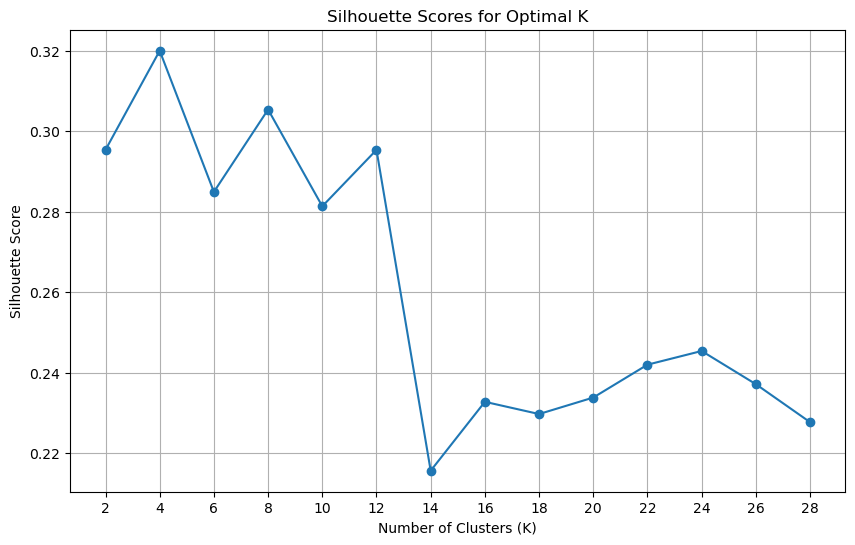

Recommended K based on highest Silhouette Score: 4
Final optimal_k_silhouette to be used: 4


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assume processed_customer_df is loaded and preprocessed
# For testing, let's create a dummy processed_customer_df if it doesn't exist
if 'processed_customer_df' not in locals() or not isinstance(processed_customer_df, pd.DataFrame):
    print("Dummy processed_customer_df created for testing.")
    # Create a dummy DataFrame: 100 samples, 5 features
    # For a real slowdown, you'd have many more samples or features
    num_samples_dummy = 100 
    num_features_dummy = 5
    if num_samples_dummy > 50: # to ensure k_range is not empty with default logic
         processed_customer_df = pd.DataFrame(np.random.rand(num_samples_dummy, num_features_dummy))
    else:
         processed_customer_df = pd.DataFrame()


if 'processed_customer_df' not in locals() or not isinstance(processed_customer_df, pd.DataFrame) or processed_customer_df.empty:
    print("Processed customer DataFrame is empty or not a DataFrame. Skipping Silhouette analysis.")
else:
    print("\n--- Determining Optimal K using Silhouette Method ---")
    print(f"Shape of processed_customer_df: {processed_customer_df.shape}")

    silhouette_scores = []
    # Adjusted k_range for potentially faster initial testing.
    # Original: range(2, 30, 3) -> [2, 5, 8, ..., 29]
    # Consider a smaller range or step if still too slow initially:
    k_range_start = 2
    k_range_end = 30 # Reduced from 30 for faster initial testing
    k_range_step = 2  # Reduced step from 3 for more granularity if desired, or keep at 3
    k_range = range(k_range_start, k_range_end, k_range_step)


    # Check if dataset size is too small for the desired k_range
    # The original check was: processed_customer_df.shape[0] < max(k_range) * 10
    # Let's ensure max(k_range) is valid before using it.
    current_max_k = max(k_range) if list(k_range) else 0

    if current_max_k > 0 and processed_customer_df.shape[0] < current_max_k:
        print(f"Warning: Number of samples ({processed_customer_df.shape[0]}) is less than the maximum K being tested ({current_max_k}).")
        print("This can lead to errors or meaningless Silhouette scores for higher K values.")
        # Adjust k_range to be at most n_samples - 1
        new_upper_k_limit = processed_customer_df.shape[0] -1
        if new_upper_k_limit < k_range_start:
            k_range = [] # Not enough samples for even the starting K
        else:
            k_range = range(k_range_start, new_upper_k_limit + 1, k_range_step)
        current_max_k = max(k_range) if list(k_range) else 0 # Update current_max_k
        print(f"Adjusted k_range due to small sample size: {list(k_range)}")


    if not list(k_range):
        print("Not enough data points or k_range is empty/too small to perform Silhouette analysis. Setting K=3 as default for next step if applicable.")
        k_range_for_plot = []
        optimal_k_silhouette = 3 # Default K
    else:
        k_range_for_plot = list(k_range)
        print(f"Testing K values in range: {k_range_for_plot}")
        
        # Optimization: Define sample size for silhouette score if dataset is large
        silhouette_sample_size = None
        if processed_customer_df.shape[0] > 5000: # Threshold for using sample_size
            silhouette_sample_size = 5000 
            print(f"Using sample_size={silhouette_sample_size} for Silhouette score calculation due to large dataset.")

        for k_val in k_range_for_plot:
            if k_val >= processed_customer_df.shape[0]:
                print(f"Skipping K={k_val} as it's >= number of samples ({processed_customer_df.shape[0]}). Appending NaN.")
                silhouette_scores.append(np.nan)
                continue
            
            print(f"\nProcessing K={k_val}...")
            try:
                print(f"  Fitting KMeans for K={k_val} (n_init=3)...")
                # Optimization: Reduced n_init for faster KMeans
                kmeans_model = KMeans(n_clusters=k_val, random_state=42, n_init=3, algorithm='lloyd')
                cluster_labels_temp = kmeans_model.fit_predict(processed_customer_df)
                
                # Silhouette score requires at least 2 unique labels and n_samples > n_clusters
                num_unique_labels = len(np.unique(cluster_labels_temp))
                if num_unique_labels > 1 and processed_customer_df.shape[0] > k_val:
                    print(f"  Calculating Silhouette Score for K={k_val} (unique labels: {num_unique_labels})...")
                    score = silhouette_score(processed_customer_df, cluster_labels_temp, sample_size=silhouette_sample_size, random_state=42)
                    silhouette_scores.append(score)
                    print(f"  Silhouette Score for K={k_val}: {score:.4f}")
                else:
                    print(f"  Could not calculate Silhouette Score for K={k_val}. Conditions not met:")
                    print(f"    Unique clusters found: {num_unique_labels} (need > 1)")
                    print(f"    Samples ({processed_customer_df.shape[0]}) vs K ({k_val}) (need samples > K)")
                    silhouette_scores.append(np.nan)
            except Exception as e:
                print(f"  Error calculating Silhouette for K={k_val}: {e}. Appending NaN.")
                silhouette_scores.append(np.nan)

    optimal_k_silhouette = None # Initialize
    if k_range_for_plot and any(not np.isnan(s) for s in silhouette_scores if isinstance(s, float)):
        plt.figure(figsize=(10, 6))
        # Filter out NaNs for plotting if any k_val was skipped or errored but others worked
        valid_k_for_plot = [k_range_for_plot[i] for i, s in enumerate(silhouette_scores) if not np.isnan(s)]
        valid_scores_for_plot = [s for s in silhouette_scores if not np.isnan(s)]

        if valid_k_for_plot: # Ensure there's something to plot
            plt.plot(valid_k_for_plot, valid_scores_for_plot, marker='o', linestyle='-')
            plt.title('Silhouette Scores for Optimal K')
            plt.xlabel('Number of Clusters (K)')
            plt.ylabel('Silhouette Score')
            plt.xticks(valid_k_for_plot) # Show ticks only for K values that were successfully processed
            plt.grid(True)
            plt.show()
            
            # Determine optimal K from valid scores
            if valid_scores_for_plot: # Redundant check, but safe
                optimal_k_silhouette = valid_k_for_plot[np.argmax(valid_scores_for_plot)]
                print(f"Recommended K based on highest Silhouette Score: {optimal_k_silhouette}")
            else: # Should not be reached if valid_k_for_plot is populated
                print("No valid Silhouette scores to determine optimal K automatically. Setting K=3 as default.")
                optimal_k_silhouette = 3
        else:
            print("No valid data to plot Silhouette scores (all were NaN or k_range was empty).")
            if not optimal_k_silhouette: optimal_k_silhouette = 3 # Default if nothing worked

    elif k_range_for_plot: # k_range_for_plot was populated, but all scores were NaN
        print("Silhouette analysis completed, but all scores were NaN. Cannot plot or recommend K. Setting K=3 as default.")
        optimal_k_silhouette = 3
    else: # k_range_for_plot was empty from the start
        print("Silhouette analysis skipped due to insufficient data or k_range size. Optimal K not determined by Silhouette.")
        # optimal_k_silhouette remains None or its default from earlier if k_range was initially empty
        if not optimal_k_silhouette: optimal_k_silhouette = 3


    # Ensure optimal_k_silhouette has a value for subsequent cells
    if optimal_k_silhouette is None:
        print("Optimal K could not be determined. Defaulting to K=3.")
        optimal_k_silhouette = 3
    else:
        print(f"Final optimal_k_silhouette to be used: {optimal_k_silhouette}")



## Cell 7: K-Means Clustering
Based on the Silhouette plot and scores from the previous step (and potentially other domain knowledge), choose a value for `K_CLUSTERS`. The K with the highest Silhouette score is often a good choice, but also consider the interpretability of the clusters.

In [6]:
if 'processed_customer_df' not in locals() or processed_customer_df.empty:
    print("Processed customer DataFrame is empty. Skipping K-Means clustering.")
    customer_df_final_with_clusters = pd.DataFrame() 
else:
    print("\n--- Performing K-Means Clustering ---")
    # !!! SET THIS VALUE BASED ON YOUR SILHOUETTE ANALYSIS (and Elbow if you run it) !!!
    K_CLUSTERS = 12 # Example value, ADJUST AS NEEDED (e.g., optimal_k_silhouette if defined)
    print(f"Using K = {K_CLUSTERS} clusters.")

    if K_CLUSTERS <= 1 or K_CLUSTERS > processed_customer_df.shape[0]:
        print(f"Error: Invalid K_CLUSTERS value ({K_CLUSTERS}) for dataset size {processed_customer_df.shape[0]}. Cannot proceed.")
        customer_df_final_with_clusters = pd.DataFrame()
    else:
        kmeans_final_model = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto')
        cluster_labels = kmeans_final_model.fit_predict(processed_customer_df)
        
        # Use customer_df_for_clustering (unscaled, selected features) for easier interpretation of cluster means
        customer_df_interpretable = customer_df_for_clustering.copy()
        
        if customer_df_interpretable.isnull().values.any():
            print("Imputing NaNs in customer_df_interpretable for cluster analysis (using median)...")
            for col in customer_df_interpretable.columns:
                if customer_df_interpretable[col].isnull().any():
                    median_val = customer_df_interpretable[col].median()
                    customer_df_interpretable[col].fillna(median_val, inplace=True)
        
        customer_df_final_with_clusters = customer_df_interpretable.copy()
        customer_df_final_with_clusters['cluster_id'] = cluster_labels
        
        print(f"\nCustomers with assigned cluster IDs (sample):")
        display_cols = ['cluster_id'] + customer_df_for_clustering.columns.tolist()[:min(3, len(customer_df_for_clustering.columns))]
        print(customer_df_final_with_clusters[display_cols].head())


--- Performing K-Means Clustering ---
Using K = 12 clusters.
Imputing NaNs in customer_df_interpretable for cluster analysis (using median)...

Customers with assigned cluster IDs (sample):
           cluster_id  avg_rating_given  prop_recommended  num_reviews
client_id                                                             
538863              5               1.0               0.0            1
540761              0               2.0               1.0            1
549704              0               5.0               1.0            1
553815              0               5.0               1.0            1
557770              0               5.0               1.0            1


## Cell 8: Analyze Clusters


--- Analyzing Cluster Characteristics ---

Cluster Summary (Mean feature values and size per cluster):
            avg_rating_given  prop_recommended  num_reviews  avg_price_reviewed  total_value_reviewed  avg_product_rating_reviewed  avg_loves_count_reviewed  num_unique_brands_reviewed  num_unique_categories_reviewed  prop_limited_edition  prop_new_product  prop_online_only  prop_sephora_exclusive  prop_on_sale_reviewed  cluster_size
cluster_id                                                                                                                                                                                                                                                                                                                                     
0                       4.63              0.99         1.63               38.97                 64.57                         4.32                103,196.93                        1.32                            1.00        

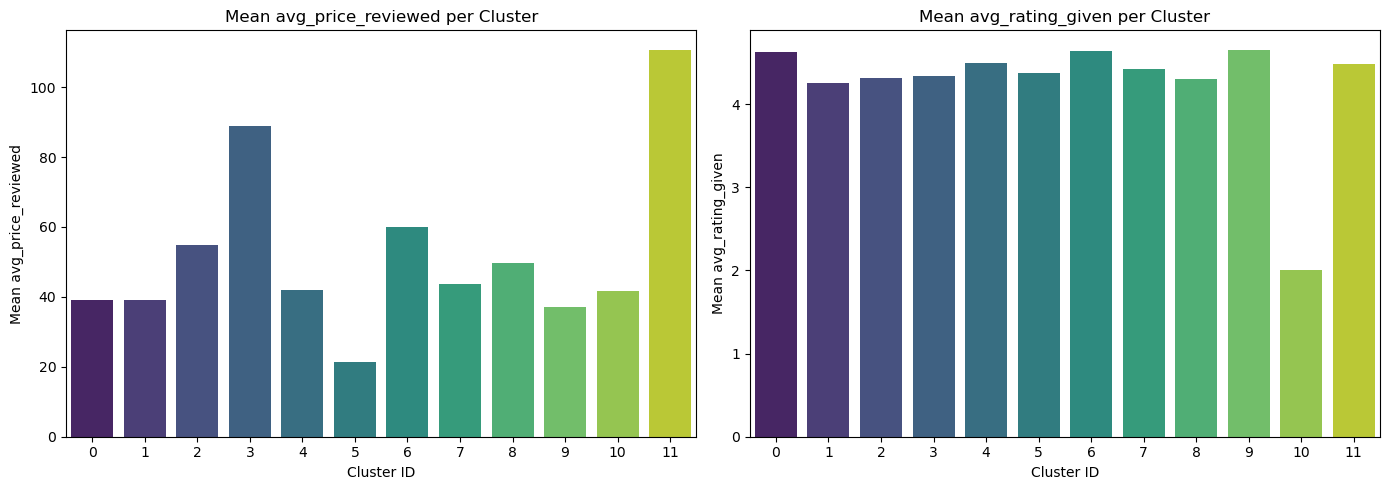

In [9]:
if 'customer_df_final_with_clusters' not in locals() or not isinstance(customer_df_final_with_clusters, pd.DataFrame) or customer_df_final_with_clusters.empty:
    print("Final customer DataFrame with clusters is not available or not a DataFrame. Skipping cluster analysis.")
else:
    print("\n--- Analyzing Cluster Characteristics ---")
    
    # Ensure 'cluster_id' column exists
    if 'cluster_id' not in customer_df_final_with_clusters.columns:
        print("Error: 'cluster_id' column not found in customer_df_final_with_clusters. Skipping analysis.")
    else:
        # Calculate mean, excluding non-numeric if any, and then select numeric for summary
        numeric_cols = customer_df_final_with_clusters.select_dtypes(include=np.number).columns.tolist()
        if 'cluster_id' in numeric_cols: # cluster_id itself shouldn't be averaged
            numeric_cols.remove('cluster_id')
        
        if not numeric_cols:
            print("Error: No numeric columns found for cluster summary (excluding cluster_id).")
            cluster_summary = pd.DataFrame()
        else:
            cluster_summary = customer_df_final_with_clusters.groupby('cluster_id')[numeric_cols].mean()

        cluster_sizes = customer_df_final_with_clusters['cluster_id'].value_counts().sort_index()
        cluster_summary['cluster_size'] = cluster_sizes
        
        print("\nCluster Summary (Mean feature values and size per cluster):")
        # Displaying with limited precision for readability
        with pd.option_context('display.float_format', '{:,.2f}'.format, 'display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
            print(cluster_summary)
        
        # Example: Visualize a couple of key features per cluster
        feature1_to_plot = 'avg_price_reviewed' 
        feature2_to_plot = 'avg_rating_given'   

        # Check if the chosen features are actually in the summary (i.e., were numeric and present)
        available_features_for_plot = [col for col in [feature1_to_plot, feature2_to_plot] if col in cluster_summary.columns]

        if len(available_features_for_plot) > 0:
            num_plots = len(available_features_for_plot)
            # Ensure number of subplots matches available features
            fig, axes = plt.subplots(1, num_plots, figsize=(7*num_plots, 5), squeeze=False) 
            
            for i, feature_to_plot in enumerate(available_features_for_plot):
                # CORRECTED LINE: Removed redundant 'hue' and 'legend' arguments
                sns.barplot(x=cluster_summary.index, y=feature_to_plot, data=cluster_summary, ax=axes[0,i], palette="viridis") 
                axes[0,i].set_title(f'Mean {feature_to_plot} per Cluster')
                axes[0,i].set_xlabel('Cluster ID')
                axes[0,i].set_ylabel(f'Mean {feature_to_plot}')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"\nNote: Example features ('{feature1_to_plot}', '{feature2_to_plot}') not available in cluster_summary for plotting.")
            print(f"Available numeric features in summary are: {cluster_summary.columns.tolist()}")

# Add a check for optimal_k_silhouette for subsequent cells that might need it.
if 'optimal_k_silhouette' not in locals():
    print("\nWarning: 'optimal_k_silhouette' not defined. Setting a default if needed by other cells.")
    # optimal_k_silhouette = 3 # Or some other sensible default


## Cell 9: Export Results

In [8]:
if 'customer_df_final_with_clusters' not in locals() or customer_df_final_with_clusters.empty or 'cluster_id' not in customer_df_final_with_clusters.columns:
    print("Clustering was not performed or 'cluster_id' is missing. Skipping export of segments.")
else:
    print("\n--- Exporting Customer Segments ---")
    output_df = customer_df_final_with_clusters[['cluster_id']].reset_index()
    # 'client_id' should be the name of the index after reset_index() if it was named 'client_id'
    if 'index' in output_df.columns and customer_df_final_with_clusters.index.name == 'client_id':
         output_df.rename(columns={'index': 'client_id'}, inplace=True)
    elif customer_df_final_with_clusters.index.name is not None and customer_df_final_with_clusters.index.name != 'client_id':
        output_df.rename(columns={customer_df_final_with_clusters.index.name : 'client_id'}, inplace=True)
    
    output_filename = "customer_segments_refined.csv"
    try:
        output_df.to_csv(output_filename, index=False)
        print(f"Successfully exported refined customer segments to {output_filename}")
        print("Output CSV sample:")
        print(output_df.head())
    except Exception as e:
        print(f"Error exporting CSV: {e}")


--- Exporting Customer Segments ---
Successfully exported refined customer segments to customer_segments_refined.csv
Output CSV sample:
   client_id  cluster_id
0     538863           5
1     540761           0
2     549704           0
3     553815           0
4     557770           0


## Customer Cluster Summaries

---

### **Cluster 0: Contented Loyalists**
* **Size:** 82,734 customers
* **Summary:** Satisfied customers who stick to familiar, moderately priced, popular products and aren't swayed by trends or sales.

---

### **Cluster 1: Disappointed Critics of Popular Goods**
* **Size:** 58,380 customers
* **Summary:** Very critical reviewers of popular, relatively low-priced items, despite the products' general popularity.

---

### **Cluster 2: Engaged Brand Explorers**
* **Size:** 41,327 customers
* **Summary:** Active and generally satisfied reviewers who try a good number of brands and show moderate interest in trends and sales.

---

### **Cluster 3: Online Channel Loyalists**
* **Size:** 43,529 customers
* **Summary:** Highly satisfied customers who predominantly purchase online-only products, often less "viral" items.

---

### **Cluster 4: Limited Edition & Sephora Exclusive Hunters (Sale Savvy)**
* **Size:** 9,678 customers
* **Summary:** Seek out limited editions and Sephora exclusives, and are the most interested in finding these items on sale.

---

### **Cluster 5: Budget Fans of Viral Hits (Sephora Exclusives)**
* **Size:** 18,507 customers
* **Summary:** Purchase very low-priced but extremely popular (viral) items, with a high preference for Sephora exclusives.

---

### **Cluster 6: Devoted Sephora Exclusive Fans**
* **Size:** 63,823 customers
* **Summary:** Highly satisfied, budget-conscious customers who overwhelmingly prefer Sephora exclusive products.

---

### **Cluster 7: New Product Aficionados (High Quality Focus)**
* **Size:** 8,112 customers
* **Summary:** Early adopters who focus on new products that also have high community ratings, often Sephora exclusives or online.

---

### **Cluster 8: High-Spending, Prolific Reviewing Brand Connoisseurs**
* **Size:** 4,263 customers
* **Summary:** Highly engaged customers who spend and review a lot, explore many brands, and show interest in new products.

---

### **Cluster 9: Premium Sale Seekers (Viral Products)**
* **Size:** 10,492 customers
* **Summary:** Purchase high-priced, popular items almost exclusively when they are on sale, often Sephora exclusives.

---

### **Cluster 10: Quality-Focused Budget Buyers**
* **Size:** 123,569 customers
* **Summary:** The largest group; very satisfied, they buy low-priced items that have excellent community ratings and are the least interested in trends or sales.

---

### **Cluster 11: Luxury Niche Loyalists**
* **Size:** 10,212 customers
* **Summary:** Spend the most per item by far, focusing on expensive, niche (less viral) products and are brand loyal.

---

### **Cluster 12: Sephora Exclusive Fans (Less Critical of Product Ratings)**
* **Size:** 27,802 customers
* **Summary:** Strongly prefer Sephora exclusives, similar to Cluster 6, but are satisfied even if those exclusives have lower overall community ratings.

---

### **Cluster 13: Super Reviewers / High-Spending Trendsetters**
* **Size:** 767 customers
* **Summary:** A very small group of power users who review, spend, and explore brands the most, focusing on high-quality, new, and often niche items.

---

## Cell 10: Conclusion & Next Steps (Refined Segmentation)

This notebook has performed customer segmentation using data from `data/processed/`, with an emphasis on careful feature selection and Silhouette analysis for determining the number of clusters. The output is `customer_segments_refined.csv`.

**Interpreting Your Clusters:**
Carefully analyze the `Cluster Summary` table (Cell 8). The key is to identify how the average feature values differ across clusters, defining distinct customer personas. Consider not just the means, but also the relative importance of features that differentiate the groups.

**Potential Next Steps & Improvements:**
* **Iterative Feature Engineering & Selection:** The selection in Cell 4 is crucial. You might iterate on this: try different sets of features, use techniques like PCA for dimensionality reduction, or look at feature importance from predictive models (if applicable to a related task) to guide selection.
* **Hyperparameter Tuning for K-Means:** While `random_state` ensures reproducibility, other parameters of KMeans could be explored.
* **Alternative Clustering Algorithms:** If K-Means results are not satisfactory or its assumptions don't hold, explore DBSCAN, Agglomerative Clustering, etc.
* **Business Validation:** Ultimately, the "best" segmentation is the one that is most actionable and provides meaningful insights for your business goals.